<a href="https://colab.research.google.com/github/Rushabh309/Sentimental-analysis-of-twitter-Data/blob/master/Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objective**

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

# **Import**

In [57]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import urllib
import requests
import gensim
import io
import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


In [58]:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from nltk import PorterStemmer

# **Upload Dataset**

In [59]:
from google.colab import files
uploaded = files.upload()

Saving test_tweets.csv to test_tweets (1).csv
Saving train_tweet.csv to train_tweet (1).csv


In [60]:
train = pd.read_csv(io.StringIO(uploaded['train_tweet.csv'].decode('utf-8')))
train_tweet = train.copy()

test = pd.read_csv(io.StringIO(uploaded['test_tweets.csv'].decode('utf-8')))
test_tweets = test.copy()

In [61]:
train.head(1)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...


In [62]:
test.head(1)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...


In [63]:
train.isnull().any()
test.isnull().any()

id       False
tweet    False
dtype: bool

# **checking out the Positive comments from the train set**

In [64]:
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


# **Checking out the Negative Comments from the Train set**

In [65]:
train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


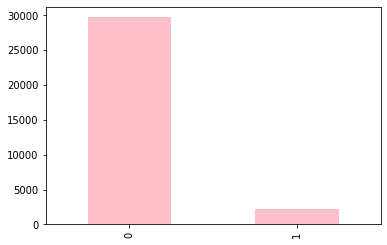

In [66]:
train['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

# **checking the distribution of tweets in the data**


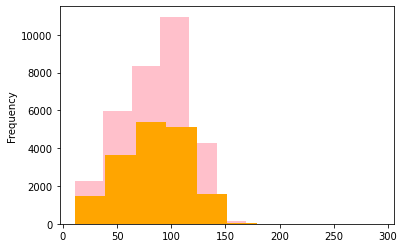

In [67]:
length_train = train['tweet'].str.len().plot.hist(color = 'pink', figsize = (6, 4))
length_test = test['tweet'].str.len().plot.hist(color = 'orange', figsize = (6, 4))

# adding a column to represent the length of the tweet


In [68]:
train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()

train.head(10)

,id,label,tweet,len
0,1,0,@user when a father is dysfunctional and is s...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in ...,86
4,5,0,factsguide: society now #motivation,39
5,6,0,[2/2] huge fan fare and big talking before the...,116
6,7,0,@user camping tomorrow @user @user @user @use...,74
7,8,0,the next school year is the year for exams.ð...,143
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,87
9,10,0,@user @user welcome here ! i'm it's so #gr...,50


In [69]:
train.groupby('label').describe()

id                                   ...   len                    
         count          mean          std   min  ...   25%   50%    75%    max
label                                            ...                          
0      29720.0  15974.454441  9223.783469   1.0  ...  62.0  88.0  107.0  274.0
1       2242.0  16074.896075  9267.955758  14.0  ...  69.0  96.0  111.0  152.0

[2 rows x 16 columns]

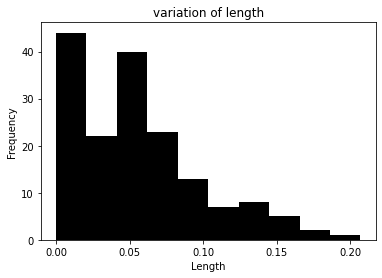

In [70]:
train.groupby('len').mean()['label'].plot.hist(color = 'black', figsize = (6, 4),)
plt.title('variation of length')
plt.xlabel('Length')
plt.show()

# **Most Frequently Occuring Words - Top 30**

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

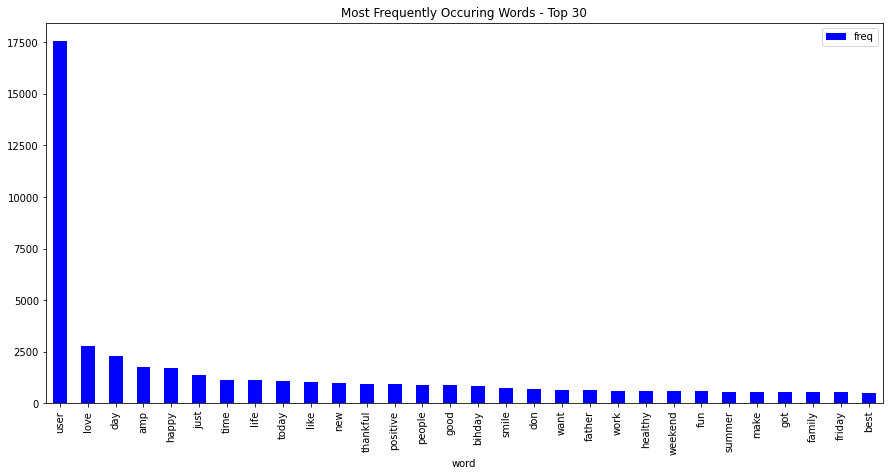

In [71]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

#**Word Cloud**

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

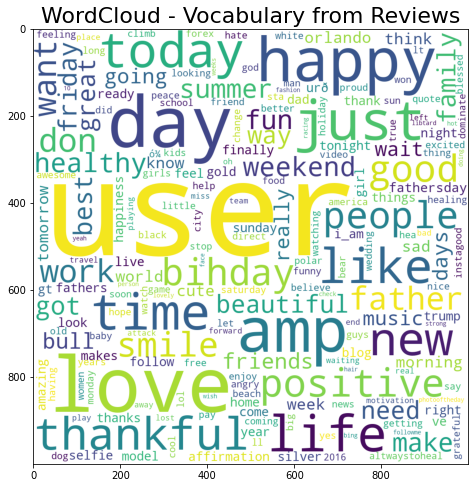

In [72]:
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

#**Plot Word Cloud Positive Word**

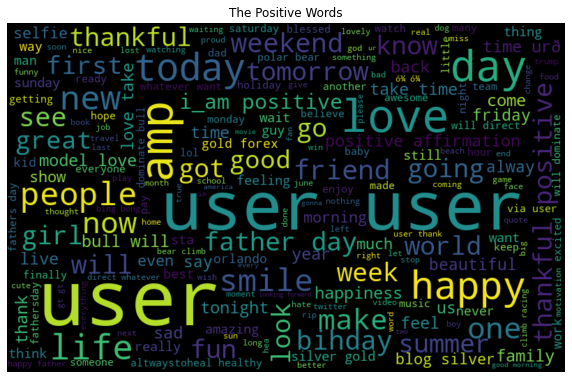

In [73]:
positive_words =' '.join([text for text in train['tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positive Words')
plt.show()

#**Plot Word Cloud negative Word**

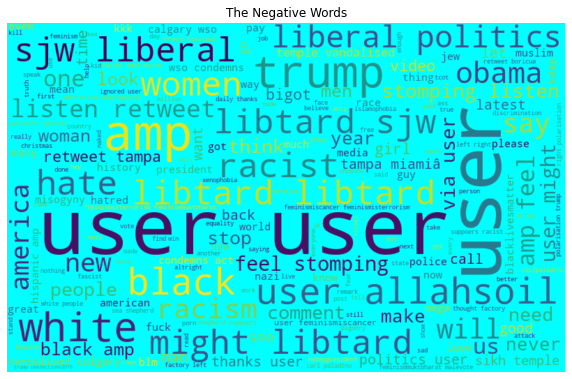

In [74]:
negative_words =' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(background_color = 'cyan', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

#**Combine**

In [75]:
combine = train.append(test,ignore_index=True,sort=True)
combine

,id,label,len,tweet
0,1,0.0,102,@user when a father is dysfunctional and is s...
1,2,0.0,122,@user @user thanks for #lyft credit i can't us...
2,3,0.0,21,bihday your majesty
3,4,0.0,86,#model i love u take with u all the time in ...
4,5,0.0,39,factsguide: society now #motivation
...,...,...,...,...
49154,49155,NaN,108,thought factory: left-right polarisation! #tru...
49155,49156,NaN,96,feeling like a mermaid ð #hairflip #neverre...
49156,49157,NaN,145,#hillary #campaigned today in #ohio((omg)) &am...
49157,49158,NaN,104,"happy, at work conference: right mindset leads..."


In [76]:
combine.head(1)

,id,label,len,tweet
0,1,0.0,102,@user when a father is dysfunctional and is s...


In [77]:
combine.tail(1)

,id,label,len,tweet
49158,49159,NaN,64,"my song ""so glad"" free download! #shoegaze ..."


# **Pattern Function**

In [78]:
def remove_pattern(text,pattern):
    
    r = re.findall(pattern,text)
    
    for i in r:
        text = re.sub(i,"",text)
    
    return text

# **Removing Twitter Handles**

Here NumPy Vectorization ‘**np.vectorize()**’ is used because it is much more faster than the conventional for loops when working on datasets of medium to large sizes.

In [79]:
combine['Tidy_Tweets'] = np.vectorize(remove_pattern)(combine['tweet'], "@[\w]*")
combine

,id,label,len,tweet,Tidy_Tweets
0,1,0.0,102,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,122,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,21,bihday your majesty,bihday your majesty
3,4,0.0,86,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,39,factsguide: society now #motivation,factsguide: society now #motivation
...,...,...,...,...,...
49154,49155,NaN,108,thought factory: left-right polarisation! #tru...,thought factory: left-right polarisation! #tru...
49155,49156,NaN,96,feeling like a mermaid ð #hairflip #neverre...,feeling like a mermaid ð #hairflip #neverre...
49156,49157,NaN,145,#hillary #campaigned today in #ohio((omg)) &am...,#hillary #campaigned today in #ohio((omg)) &am...
49157,49158,NaN,104,"happy, at work conference: right mindset leads...","happy, at work conference: right mindset leads..."


# **Removing Punctuation, Numbers And Special Characters**

Here '**str.replace()**' is used to convert the punctuation, number and special characters with white space.

In [80]:
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace("[^a-zA-Z#]", " ")
combine

,id,label,len,tweet,Tidy_Tweets
0,1,0.0,102,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,122,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0.0,21,bihday your majesty,bihday your majesty
3,4,0.0,86,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,39,factsguide: society now #motivation,factsguide society now #motivation
...,...,...,...,...,...
49154,49155,NaN,108,thought factory: left-right polarisation! #tru...,thought factory left right polarisation #tru...
49155,49156,NaN,96,feeling like a mermaid ð #hairflip #neverre...,feeling like a mermaid #hairflip #neverre...
49156,49157,NaN,145,#hillary #campaigned today in #ohio((omg)) &am...,#hillary #campaigned today in #ohio omg am...
49157,49158,NaN,104,"happy, at work conference: right mindset leads...",happy at work conference right mindset leads...


# **Removing Stop Words**

Here '**lambda**'(The expression is evaluated and returned) and '**join()**' is used to string from evaluated object.

In [81]:
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combine.head(10)

,id,label,len,tweet,Tidy_Tweets
0,1,0.0,102,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,122,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,21,bihday your majesty,bihday your majesty
3,4,0.0,86,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,39,factsguide: society now #motivation,factsguide society #motivation
5,6,0.0,116,[2/2] huge fan fare and big talking before the...,huge fare talking before they leave chaos disp...
6,7,0.0,74,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0.0,143,the next school year is the year for exams.ð...,next school year year exams think about that #...
8,9,0.0,87,we won!!! love the land!!! #allin #cavs #champ...,love land #allin #cavs #champions #cleveland #...
9,10,0.0,50,@user @user welcome here ! i'm it's so #gr...,welcome here


# **Tokenization**
Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens. We tokenize our tweets because we will apply Stemming in the next step.

In [82]:
tokenized_tweet = combine['Tidy_Tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: Tidy_Tweets, dtype: object

# **Stemming**
Stemming is a process of stripping the suffixes from a tokenized tweet.

In [83]:
ps = PorterStemmer()

In [84]:
tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: Tidy_Tweets, dtype: object

# **Combining Back To Tweet**

In [85]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

In [86]:
combine['Tidy_Tweets'] = tokenized_tweet
combine.head()

,id,label,len,tweet,Tidy_Tweets
0,1,0.0,102,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0.0,122,@user @user thanks for #lyft credit i can't us...,thank #lyft credit caus they offer wheelchair ...
2,3,0.0,21,bihday your majesty,bihday your majesti
3,4,0.0,86,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,39,factsguide: society now #motivation,factsguid societi #motiv


# **Collecting the hashtags**

In [87]:
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [88]:
# extracting hashtags from non racist/sexist tweets
HT_positive = hashtag_extract(train['tweet'][train['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(train['tweet'][train['label'] == 1])

# unnesting list
HT_positive = sum(HT_positive,[])
HT_negative = sum(HT_negative,[])

#**Selecting Top 20 most frequent use Positive Hashtags**

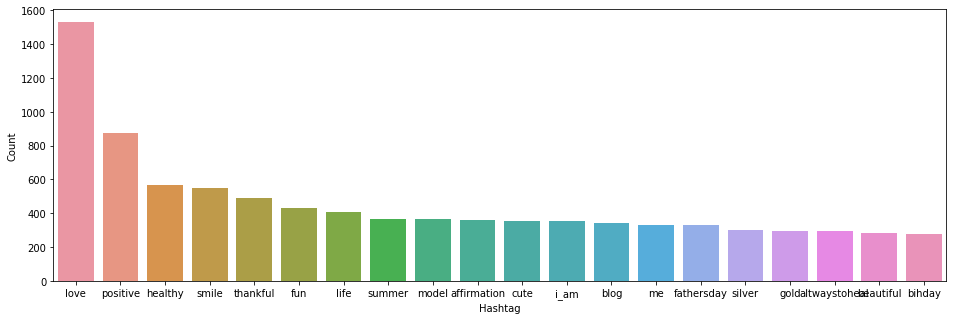

In [89]:
a = nltk.FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

# **Selecting Top 20 most frequent use Negative Hashtags**     


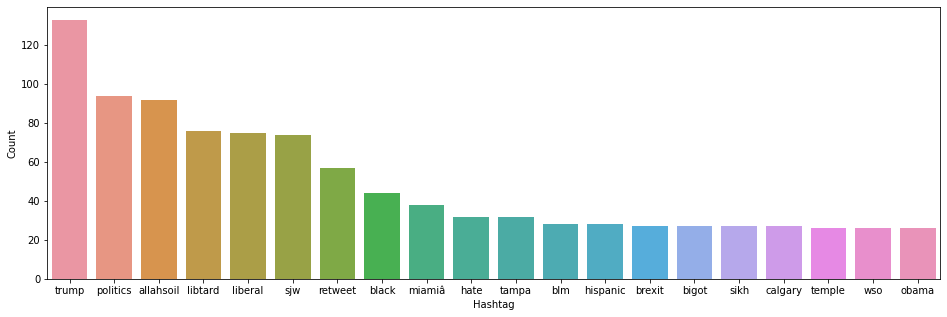

In [90]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

# **Extracting Features from cleaned Tweets**

In [91]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combine['Tidy_Tweets'])
df_bow = pd.DataFrame(bow.todense())

# **TF-IDF**
TF-IDF stands for Term Frequency-Inverse Document Frequency, and the TF-IDF weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. 


1.   The first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document.
2.   The second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF-IDF = TF * IDF

We have a package available for this in Scikit-Learn known as TfidfVectorizer.


In [92]:
tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')
tfidf_matrix=tfidf.fit_transform(combine['Tidy_Tweets'])
df_tfidf = pd.DataFrame(tfidf_matrix.todense())
df_tfidf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.532509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624002,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.411886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Splitting our dataset into Training and Validation Set**

In [93]:
train_bow = bow[:31962]
train_bow.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [94]:
train_tfidf_matrix = tfidf_matrix[:31962]
train_tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

#**Spliting**

In [95]:
x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(train_bow,train['label'],test_size=0.3,random_state=2)
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix,train['label'],test_size=0.3,random_state=17)

# **Logistic Regression**

In [96]:
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')

In [97]:
Log_Reg.fit(x_train_bow,y_train_bow)
prediction_bow = Log_Reg.predict_proba(x_valid_bow)
prediction_int = prediction_bow[:,1]>=0.3
prediction_int = prediction_int.astype(np.int)
log_bow = f1_score(y_valid_bow, prediction_int)
log_bow

0.5721352019785655

In [98]:
Log_Reg.fit(x_train_tfidf,y_train_tfidf)
prediction_tfidf = Log_Reg.predict_proba(x_valid_tfidf)
prediction_int = prediction_tfidf[:,1]>=0.3
prediction_int = prediction_int.astype(np.int)
log_tfidf = f1_score(y_valid_tfidf, prediction_int)
log_tfidf

0.5862068965517241

In [99]:
test_tfidf = tfidf_matrix[31962:]
test_pred = Log_Reg.predict_proba(test_tfidf)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]

In [100]:
submission.tail(10)

,id,label
17187,49150,0
17188,49151,1
17189,49152,0
17190,49153,0
17191,49154,0
17192,49155,1
17193,49156,0
17194,49157,0
17195,49158,0
17196,49159,0


# **Decision Trees**

In [101]:
model = DecisionTreeClassifier()
model.fit(x_train_bow, y_train_bow)

y_pred = model.predict(x_valid_bow)

print("Training Accuracy :", model.score(x_train_bow, y_train_bow))
print("Validation Accuracy :", model.score(x_valid_bow, y_valid_bow))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid_bow, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid_bow, y_pred)
print(cm)

Training Accuracy : 0.991820497921602
Validation Accuracy : 0.9259568255292523
f1 score : 0.5136986301369864
[[8504  406]
 [ 304  375]]


In [102]:
model = DecisionTreeClassifier()
model.fit(x_train_tfidf, y_train_tfidf)

y_pred = model.predict(x_valid_tfidf)

print("Training Accuracy :", model.score(x_train_tfidf, y_train_tfidf))
print("Validation Accuracy :", model.score(x_valid_tfidf, y_valid_tfidf))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid_tfidf, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid_tfidf, y_pred)
print(cm)

Training Accuracy : 0.9914182273275823
Validation Accuracy : 0.941599749713213
f1 score : 0.5447154471544715
[[8694  247]
 [ 313  335]]


# **Decision Random Forcast Classifier**

In [103]:
model = RandomForestClassifier()
model.fit(x_train_bow, y_train_bow)

y_pred = model.predict(x_valid_bow)

print("Training Accuracy :", model.score(x_train_bow, y_train_bow))
print("Validation Accuracy :", model.score(x_valid_bow, y_valid_bow))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid_bow, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid_bow, y_pred)
print(cm)

Training Accuracy : 0.991820497921602
Validation Accuracy : 0.9425383251642507
F1 score : 0.5822592873388931
[[8654  256]
 [ 295  384]]


In [104]:
model = RandomForestClassifier()
model.fit(x_train_tfidf, y_train_tfidf)

y_pred = model.predict(x_valid_tfidf)

print("Training Accuracy :", model.score(x_train_tfidf, y_train_tfidf))
print("Validation Accuracy :", model.score(x_valid_tfidf, y_valid_tfidf))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid_tfidf, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid_tfidf, y_pred)
print(cm)

Training Accuracy : 0.9913735305949135
Validation Accuracy : 0.9529669412868912
F1 score : 0.5983971504897595
[[8802  139]
 [ 312  336]]


**Calculating Accuracy**

In [105]:
print(classification_report(y_valid_tfidf,prediction_int))
print(accuracy_score(y_valid_tfidf,prediction_int))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      8941
           1       0.66      0.52      0.59       648

    accuracy                           0.95      9589
   macro avg       0.82      0.75      0.78      9589
weighted avg       0.95      0.95      0.95      9589

0.9499426426113254


# **Highest Accuracy with Logistic Regression TF-IDF 0.9499426426113254**



# **tokenizing the words present in the training set**

In [106]:
tokenized_tweet = train['tweet'].apply(lambda x: x.split()) 

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['tweet']), epochs=20)

(6109802, 8411580)

In [107]:
model_w2v.wv.most_similar(positive = "dinner")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('spaghetti', 0.6687301397323608),
 ('bay.', 0.6029534339904785),
 ('#wanderlust', 0.597032368183136),
 ('#prosecco', 0.5936300158500671),
 ('willow', 0.5917192697525024),
 ('mesa', 0.5889939069747925),
 ('3pm', 0.5881097316741943),
 ('coaching', 0.5867060422897339),
 ('#godisgood', 0.5850496292114258),
 ('podium', 0.584385871887207)]

In [108]:
model_w2v.wv.most_similar(negative = "hate")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('#yay', -0.009138934314250946),
 ('#apple', -0.050364427268505096),
 ('#gym', -0.055847447365522385),
 ('lip', -0.057362038642168045),
 ('#hype', -0.06329387426376343),
 ('#fl', -0.06397992372512817),
 ('currently', -0.06529279053211212),
 ('#wednesdaywisdom', -0.07503443211317062),
 ('final', -0.07549823075532913),
 ('ð\x9f\x98\x81', -0.07719305157661438)]

In [109]:
model_w2v.wv.most_similar(positive = "apple")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('mytraining', 0.7050607204437256),
 ('"mytraining"', 0.7009128332138062),
 ('training"', 0.6896451115608215),
 ('app,', 0.6395446062088013),
 ('"my', 0.6141483783721924),
 ('app', 0.5934624671936035),
 ('known', 0.5780305862426758),
 ('humans.', 0.5701639652252197),
 ("domino's", 0.569395899772644),
 ('ta', 0.5668967366218567)]

In [110]:
model_w2v.wv.most_similar(positive = "cancer")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ways.', 0.7334414720535278),
 ('answer.', 0.7305451035499573),
 ('aol', 0.7266777753829956),
 ('ownership', 0.7215396165847778),
 ('champion,', 0.720851480960846),
 ('level.', 0.7177951335906982),
 ('homeland', 0.7166669368743896),
 ("society's", 0.715934157371521),
 ('#merica', 0.7154732942581177),
 ('roots', 0.7150588035583496)]